# Population density trends in India (2010 vs 2015)

Gridded Population of the world is a rich datasource that combines census information from the world and uses land use/ water masks to allot them to spatial grids across the world. Let us explore this dataset for India, visualizing patterns such as spatial clusters and trends over time.

In [1]:
import georasters as gr
import rasterio
from rasterio.features import shapes
import operator
from osgeo import gdal, gdalnumeric, ogr, osr
import ogr
import subprocess
import geopandas as gp
import os
import subprocess
import glob
import pysal
import gmaps
from IPython.display import Latex
import matplotlib.pyplot as plt
import gmaps.geojson_geometries
import json
gdal.UseExceptions()

%matplotlib inline 

In [2]:
DATA_FOLDER = os.path.join('..', 'data')
gmaps.configure(api_key="")

# Get gridded population data

I [downloaded](http://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev10/data-download) data for the years 2010 and 2015, since the basis census data for India is from 2011, and extrapolation for 1 census period is reasonable. 

In [3]:
rstr_2015_world = os.path.join(DATA_FOLDER, '2015-world-grid', 'gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev10_2015_30_sec.tif')
rstr_2010_world = os.path.join(DATA_FOLDER, '2010-world-grid', 'gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev10_2010_30_sec.tif')

Since this dataset includes rasters for the whole, it must be clipped with a rasters that correspond to the country of interest. Getting the correct India boundary shape file from [this](https://github.com/datameet/maps) community sourced repository and cleaning it, to remove self-intersecting features,

In [4]:
def clean_geom(shp_file):
    gk500 = ogr.Open(
    shp_file, 1) # <====== 1 = update mode
    gk_lyr = gk500.GetLayer()

    for feature in gk_lyr:
        geom = feature.GetGeometryRef()
        if not geom.IsValid():
            feature.SetGeometry(geom.Buffer(0)) # <====== SetGeometry
            gk_lyr.SetFeature(feature) # <====== SetFeature
            assert feature.GetGeometryRef().IsValid() # Doesn't fail

    gk_lyr.ResetReading()
    assert all(feature.GetGeometryRef().IsValid() for feature in gk_lyr)

In [5]:
clean_geom(os.path.join(DATA_FOLDER, 'india-boundary', 'Admin2.shp'))

Clipping the world population grid files,

In [45]:
def clip_raster(input_file, mask_shp_file):
    output_file = input_file.replace('.tif', '_clipped.tif')
    subprocess.call('gdalwarp -cutline ' + mask_shp_file + ' -crop_to_cutline ' + input_file + ' ' + output_file, shell=True)

    # Build image overviews
    subprocess.call('gdaladdo --config COMPRESS_OVERVIEW DEFLATE ' + output_file + ' 2 4 8 16 32 64', shell=True)

    print('Done.' + '\n')

In [46]:
clip_raster(rstr_2010_world, os.path.join(DATA_FOLDER, 'india-boundary', 'Admin2.shp'))
clip_raster(rstr_2015_world, os.path.join(DATA_FOLDER, 'india-boundary', 'Admin2.shp'))

Done.

Done.



In [50]:
rstr_2015_world = gr.from_file(rstr_2015_world.replace('.tif', '_clipped.tif'))
rstr_2015_world = gr.from_file(rstr_2010_world.replace('.tif', '_clipped.tif'))

Plotting the file to check,

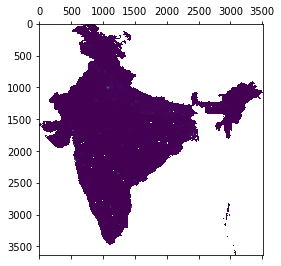

In [48]:
rstr_2015_world.plot()

Converting the rasters to polygons for analyses,

In [52]:
def raster_to_polygons(raster):
    with rasterio.drivers():
        with rasterio.open(raster) as src:
            image = src.read(1) # first band
            results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                shapes(image, mask=None, transform=src.affine)))
    return (results)

In [59]:
gdf_2015_world  = gp.GeoDataFrame.from_features(list(raster_to_polygons(os.path.join(DATA_FOLDER, '2015-world-grid', 'gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev10_2015_30_sec_clipped.tif'))))
gdf_2010_world  = gp.GeoDataFrame.from_features(list(raster_to_polygons(os.path.join(DATA_FOLDER, '2010-world-grid', 'gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev10_2010_30_sec_clipped.tif'))))

In [66]:
gdf_2015_world['ID'] = gdf_2015_world.index
gdf_2010_world['ID'] = gdf_2010_world.index

In [67]:
gdf_2015_world.to_file(os.path.join(DATA_FOLDER, '2015-world-grid', 'gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev10_2015_30_sec.shp'))
gdf_2010_world.to_file(os.path.join(DATA_FOLDER, '2010-world-grid', 'gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev10_2010_30_sec.shp'))

# Local Indicators of Spatial Association (LISA) clusters

A global measure of Spatial autocorrelation, Moran's I, describes how clustered the overall dataset is. This can be represented as, $$I = \frac N W \frac {\sum_i \sum_j w_{ij}(x_i-\bar x) (x_j-\bar x)} {\sum_i (x_i-\bar x)^2}$$

where N is the number of spatial units indexed by i and j, x  is the variable of interest, w is a matrix of spatial weights with zeroes on the diagonal (i.e., $w_{ii} = 0$) and W is the sum of $w_{ij}$. This measure however assumes homogeneity of the dataset, and does not reveal variations in this statistic across regions. Localized variations can be derived from this global measure by expressing this as a sum of the individual spatial units' I statistics,  $$I = \sum_i \frac {(x_i-\bar x)} {\sum_i (x_i-\bar x)^2} N  \sum_j w_{ij} (x_j-\bar x) $$ $$I = \sum_i \frac {(x_i-\bar x) N} {\sum_i (x_i-\bar x)^2} \sum_j w_{ij} (x_j-\bar x) $$
$$I = \sum_i \frac {I_i} {N} $$
where ${I_i} = \frac {Z_i} {m_2} \sum_j w_{ij} (x_j-\bar x)$ and $m_2 = \frac {\sum_i (x_i-\bar x)^2} {N}$

This statistic can be used to classify the observations into four clusters, those with high values surrounded by high values, low values surrounded by high values and vice versa. 

Creating queens weights and creating spatially pop density variables,

In [ ]:
w_2015 = pysal.weights.Queen.from_dataframe(gdf_2015_world)
w_2014 = pysal.weights.Queen.from_dataframe(gdf_2014_world)

Since this will attempt to create an NXN matrix, it will take a while. I instead choose to use GeoDa to create the weights files and load them. 

In [5]:
gdf_2015_world = gp.read_file(os.path.join(DATA_FOLDER, '2015-world-grid', 'filtered.shp'))
gdf_2010_world = gp.read_file(os.path.join(DATA_FOLDER, '2010-world-grid', 'filtered.shp'))
W_2015 = pysal.open(os.path.join(DATA_FOLDER, '2015-world-grid', 'filtered_q.gal')).read()
W_2010 = pysal.open(os.path.join(DATA_FOLDER, '2010-world-grid', 'filtered_q.gal')).read()

/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 165 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 73, 137, 892, 1596, 1686, 2310, 20107, 29322, 65380, 80807, 82696, 83099, 101426, 102323, 103666, 111271, 122609, 136759, 167792, 169479, 181696, 183361, 196218, 207540, 226494, 228570, 228899, 230787, 231022, 231525, 233040, 233594, 235228, 246263, 253825, 257677, 258827, 260241, 260493, 262167, 262413, 263246, 265156, 265166, 265498, 266053, 266062, 269907, 274726, 276745, 279952, 283222, 283754, 285530, 288558, 289071, 289353, 289664, 290363, 290497, 290683, 291258, 291267, 291518, 295949, 296718, 297957, 298769, 305081, 320514, 321705, 323296, 339532, 342820, 396215, 397028, 401773, 404291, 404383, 409123, 409374, 413402, 421202, 429101, 429883, 433455, 435234, 438

In [6]:
W_2015.transform = 'R'
W_2010.transform = 'R'

('WARNING: ', '73', ' is an island (no neighbors)')
('WARNING: ', '137', ' is an island (no neighbors)')
('WARNING: ', '892', ' is an island (no neighbors)')
('WARNING: ', '1596', ' is an island (no neighbors)')
('WARNING: ', '1686', ' is an island (no neighbors)')
('WARNING: ', '2310', ' is an island (no neighbors)')
('WARNING: ', '20107', ' is an island (no neighbors)')
('WARNING: ', '29322', ' is an island (no neighbors)')
('WARNING: ', '65380', ' is an island (no neighbors)')
('WARNING: ', '80807', ' is an island (no neighbors)')
('WARNING: ', '82696', ' is an island (no neighbors)')
('WARNING: ', '83099', ' is an island (no neighbors)')
('WARNING: ', '101426', ' is an island (no neighbors)')
('WARNING: ', '102323', ' is an island (no neighbors)')
('WARNING: ', '103666', ' is an island (no neighbors)')
('WARNING: ', '111271', ' is an island (no neighbors)')
('WARNING: ', '122609', ' is an island (no neighbors)')
('WARNING: ', '136759', ' is an island (no neighbors)')
('WARNING: ', 

('WARNING: ', '65381', ' is an island (no neighbors)')
('WARNING: ', '80807', ' is an island (no neighbors)')
('WARNING: ', '82695', ' is an island (no neighbors)')
('WARNING: ', '83098', ' is an island (no neighbors)')
('WARNING: ', '101426', ' is an island (no neighbors)')
('WARNING: ', '102323', ' is an island (no neighbors)')
('WARNING: ', '103667', ' is an island (no neighbors)')
('WARNING: ', '111271', ' is an island (no neighbors)')
('WARNING: ', '122606', ' is an island (no neighbors)')
('WARNING: ', '136752', ' is an island (no neighbors)')
('WARNING: ', '167782', ' is an island (no neighbors)')
('WARNING: ', '169469', ' is an island (no neighbors)')
('WARNING: ', '181686', ' is an island (no neighbors)')
('WARNING: ', '183351', ' is an island (no neighbors)')
('WARNING: ', '196205', ' is an island (no neighbors)')
('WARNING: ', '207529', ' is an island (no neighbors)')
('WARNING: ', '226483', ' is an island (no neighbors)')
('WARNING: ', '228561', ' is an island (no neighbors

In [6]:
lisa_2015 = pysal.Moran_Local(gdf_2015_world['raster_val'].values, W_2015)
lisa_2010 = pysal.Moran_Local(gdf_2010_world['raster_val'].values, W_2010)

/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/manu/anaconda3/envs/gdal2/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [ ]:
gdf_2015_world['C_ID'] = lisa_2015.q
gdf_2010_world['C_ID'] = lisa_2010.q
gdf_2015_world['PP_VAL'] = lisa_2015.p_sim 
gdf_2010_world['PP_VAL'] = lisa_2010.p_sim

In [10]:
gdf_2015_world['significance'] = gdf_2015_world['PP_VAL'] < 0.5
gdf_2010_world['significance'] = gdf_2010_world['PP_VAL'] < 0.5

# 2010 LISA Clusters

In [12]:
gdf_india = gp.read_file(os.path.join(DATA_FOLDER, 'india-boundary', 'Admin2.shp'))

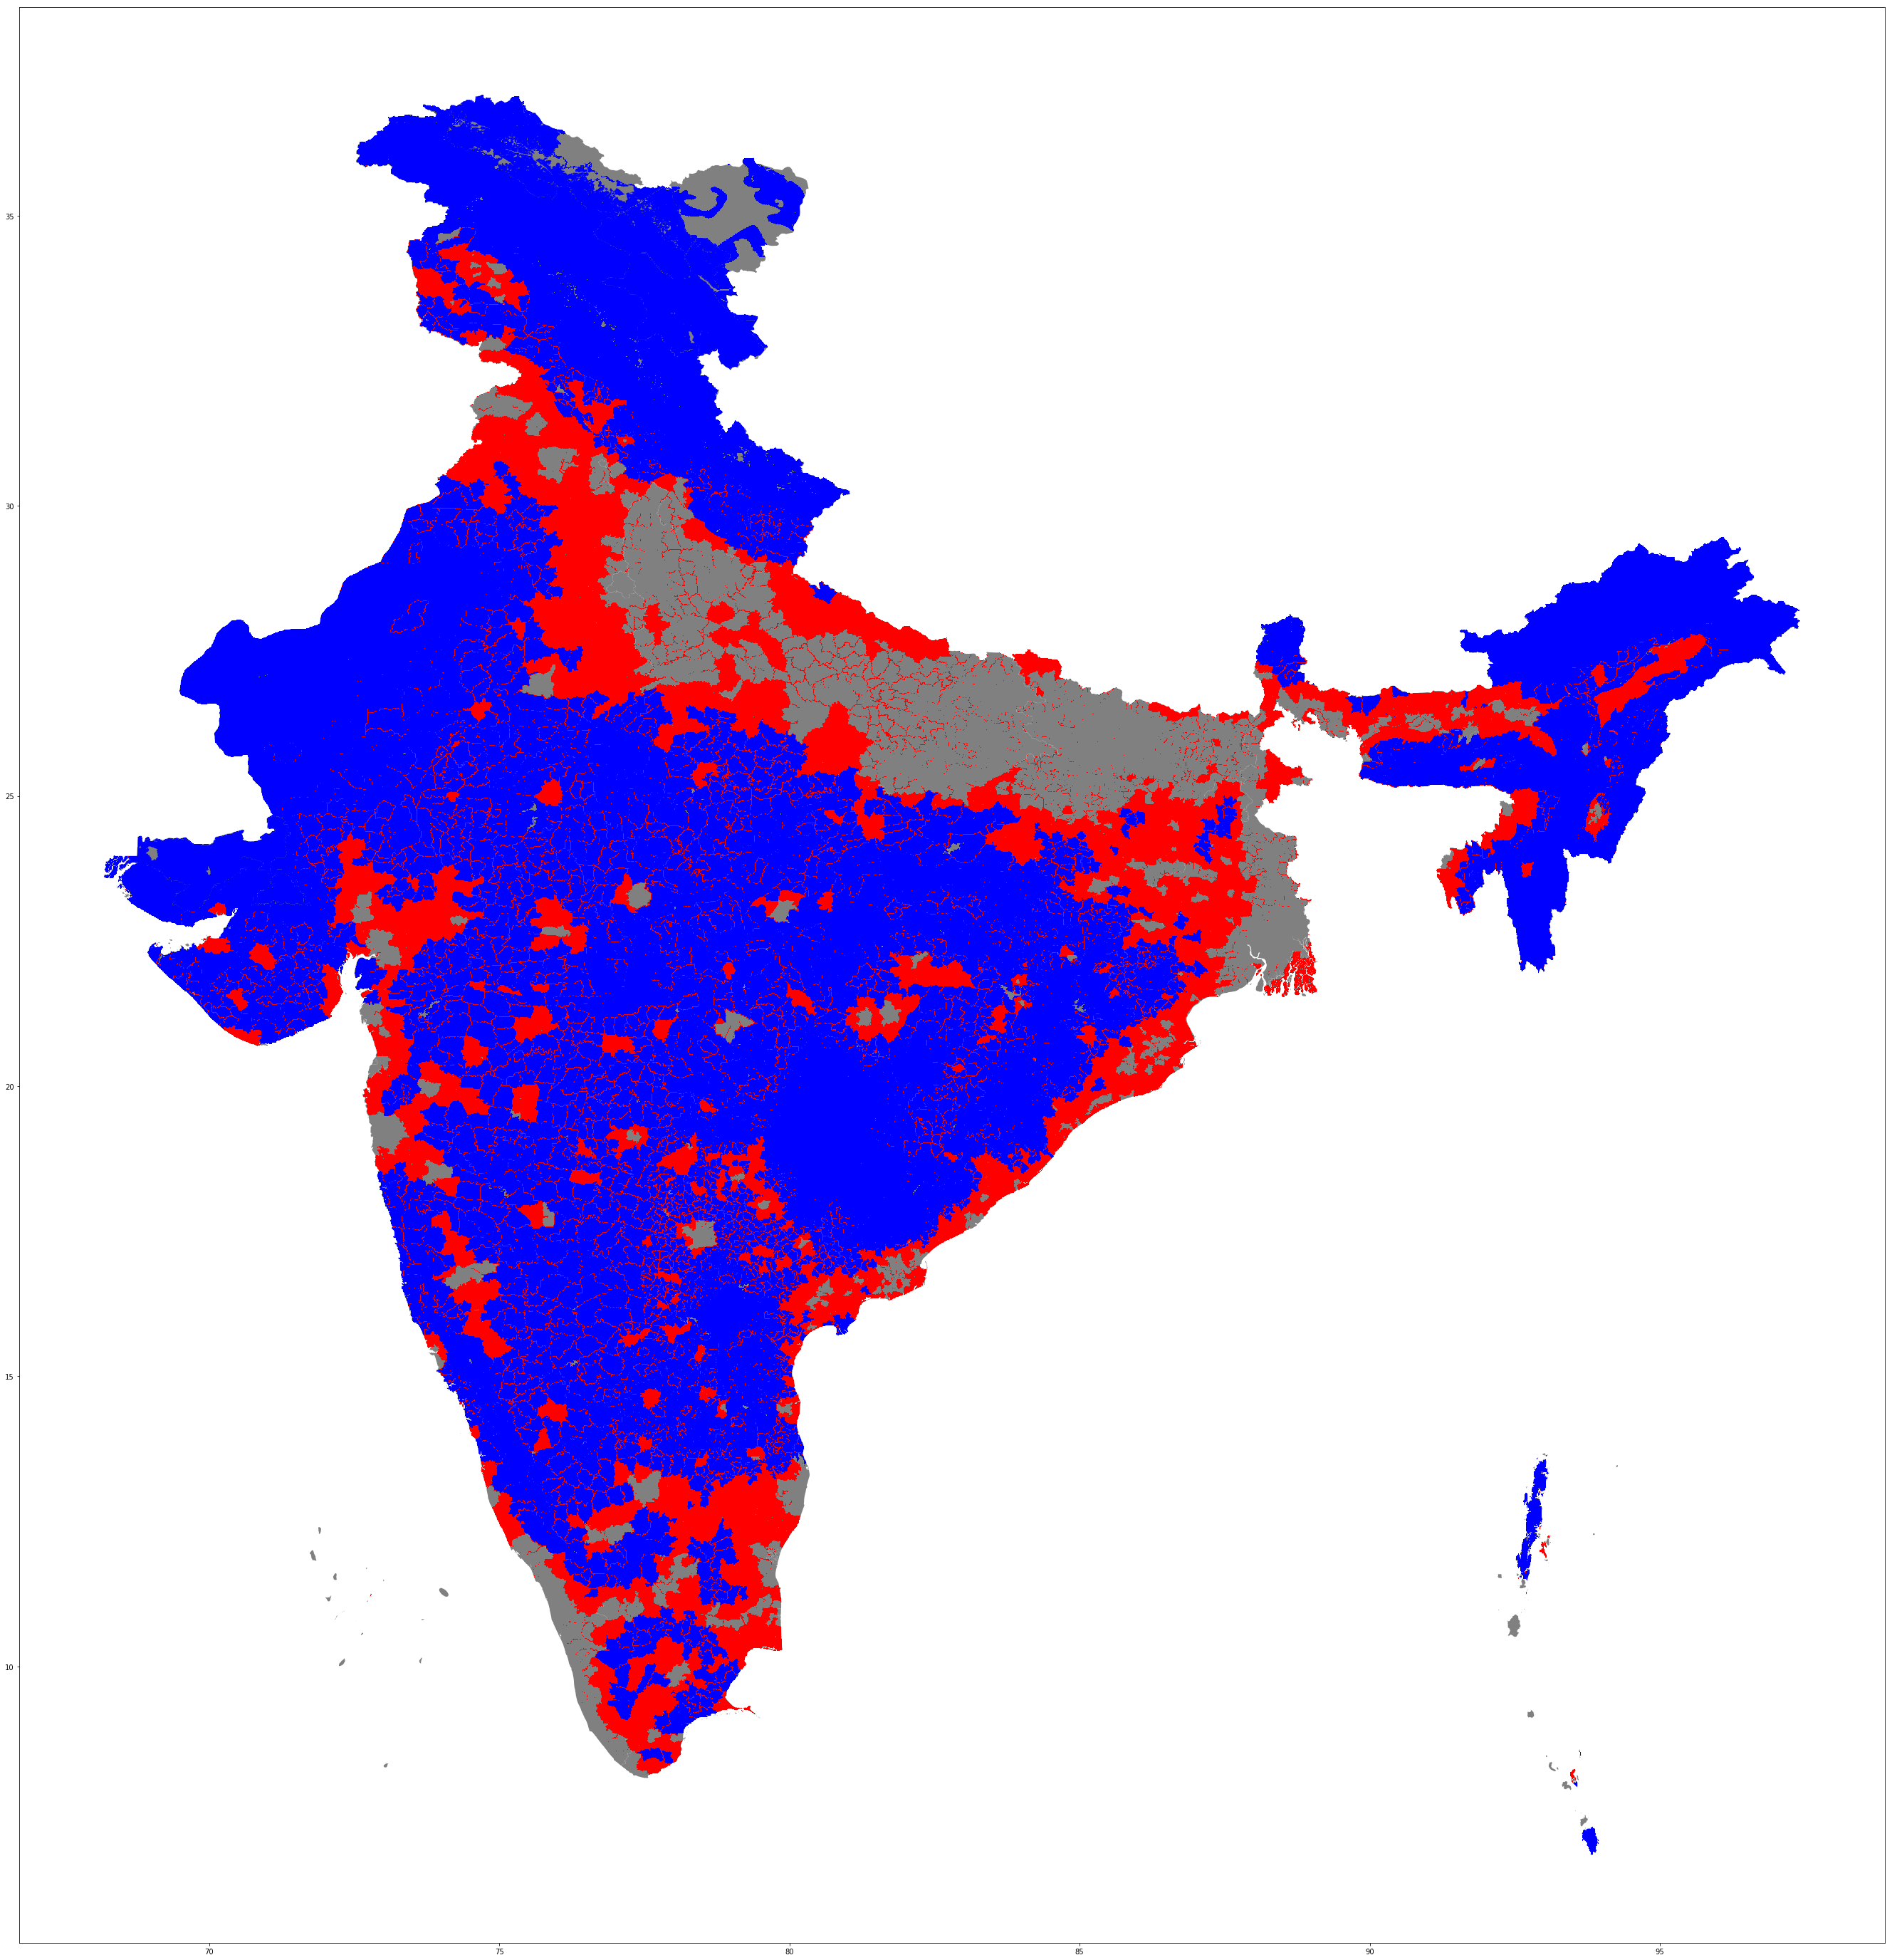

In [15]:
base = gdf_india.plot(figsize=(50,50), color='grey')
gdf_2010_world.loc[(gdf_2010_world['C_ID']==0) & (gdf_2010_world['significance']==True), ].plot(ax=base, color='red')
gdf_2010_world.loc[(gdf_2010_world['C_ID']==2) & (gdf_2010_world['significance']==True), ].plot(ax=base, color='blue')
# gdf_2010_world.loc[(gdf_2010_world['C_ID']==1) & (gdf_2010_world['significance']==True), ].plot(ax=base, color='#83cef4')
# gdf_2010_world.loc[(gdf_2010_world['C_ID']==3) & (gdf_2010_world['significance']==True), ].plot(ax=base, color='#e59696')

# 2015 LISA Clusters

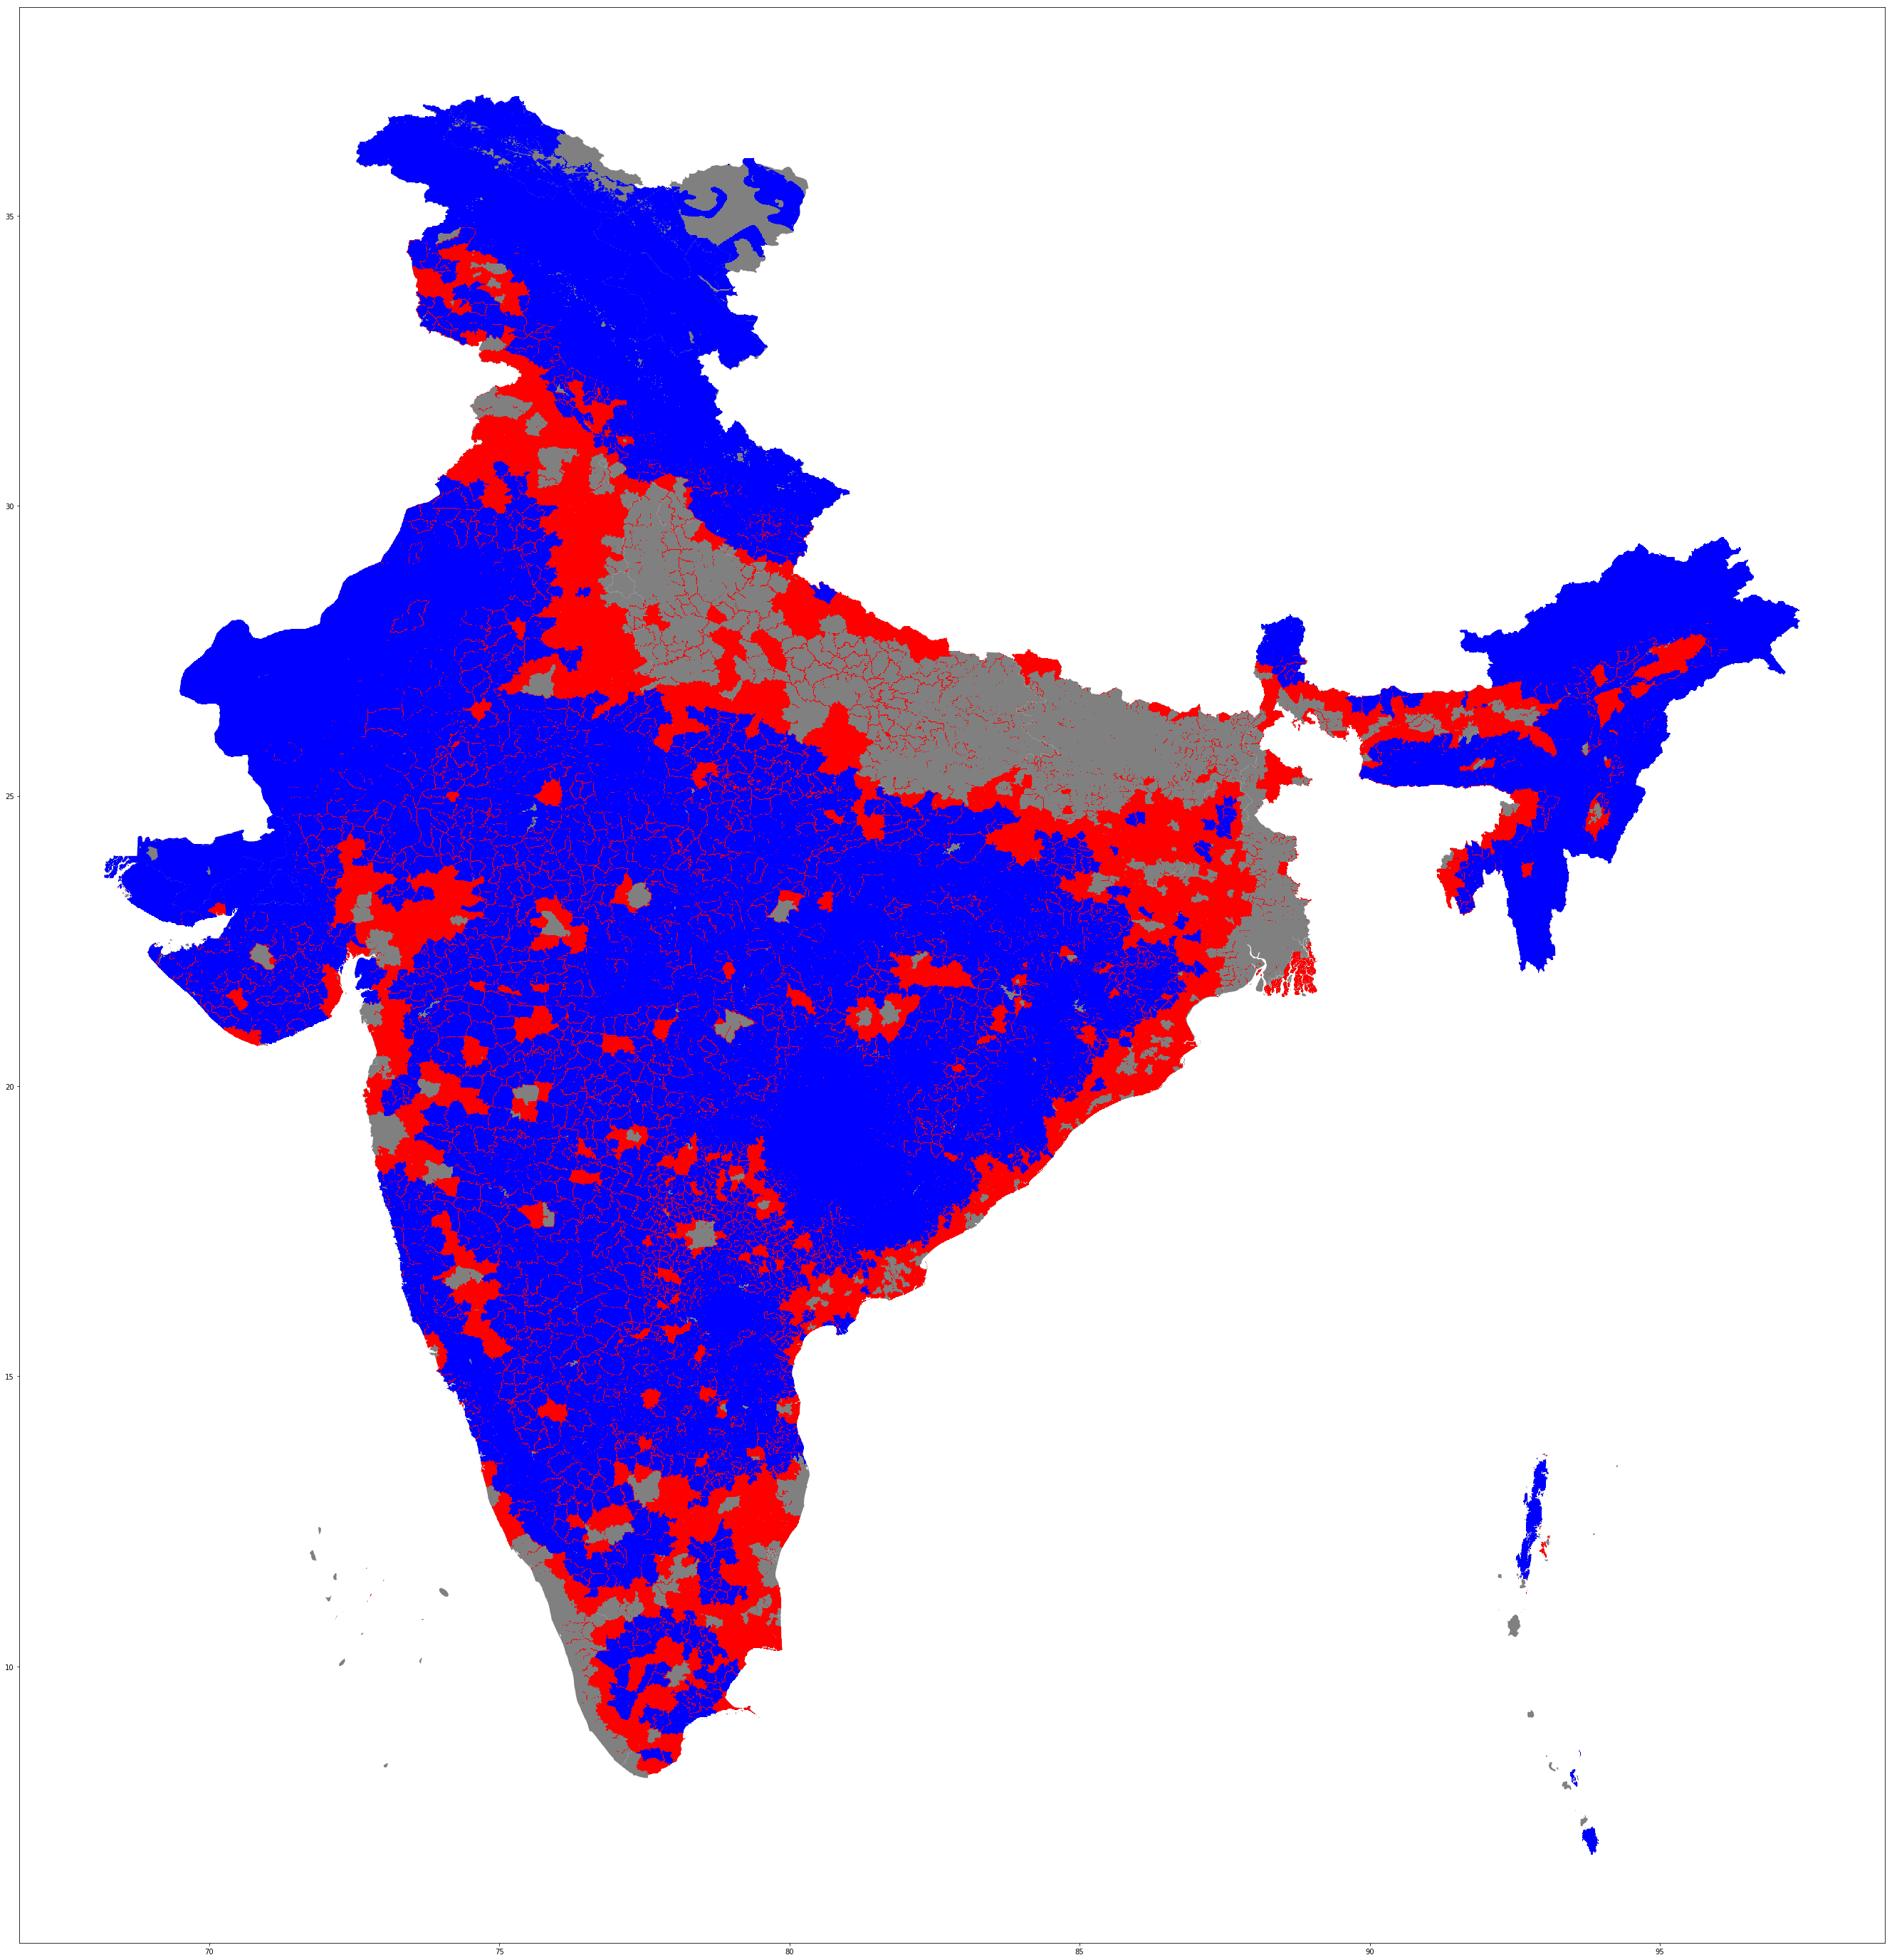

In [16]:
base = gdf_india.plot(figsize=(50,50), color='grey')
gdf_2015_world.loc[(gdf_2015_world['C_ID']==0) & (gdf_2015_world['significance']==True), ].plot(ax=base, color='red')
gdf_2015_world.loc[(gdf_2015_world['C_ID']==2) & (gdf_2015_world['significance']==True), ].plot(ax=base, color='blue')
# gdf_2015_world.loc[(gdf_2015_world['C_ID']==1) & (gdf_2015_world['significance']==True), ].plot(ax=base, color='#83cef4')
# gdf_2015_world.loc[(gdf_2015_world['C_ID']==3) & (gdf_2015_world['significance']==True), ].plot(ax=base, color='#e59696')

While the overall trend of high density clusters remain centered around big cities, notable observations include,

1. New high density clusters along West Bengal/ Bangladesh border in 2015.
2. High density clusters around big cities are slightly bigger in 2015, implying more suburban developments. 

Using google maps as base,

In [ ]:
fig = gmaps.figure()
hh_layer = gmaps.geojson_layer(
              json.loads(gdf_2010_world.loc[(gdf_2010_world['C_ID']==0) & (gdf_2010_world['significance']==True), ].geometry.to_json()),
              fill_color='red',
              stroke_color='red',
              fill_opacity=0.8)
ll_layer = gmaps.geojson_layer(
              json.loads(gdf_2010_world.loc[(gdf_2010_world['C_ID']==2) & (gdf_2010_world['significance']==True), ].geometry.to_json()),
              fill_color='blue',
              stroke_color='blue',
              fill_opacity=0.8)
lh_layer = gmaps.geojson_layer(
              json.loads(gdf_2010_world.loc[(gdf_2010_world['C_ID']==1) & (gdf_2010_world['significance']==True), ].geometry.to_json()),
              fill_color='#83cef4',
              stroke_color='#83cef4',
              fill_opacity=0.8)
hl_layer = gmaps.geojson_layer(
              json.loads(gdf_2010_world.loc[(gdf_2010_world['C_ID']==3) & (gdf_2010_world['significance']==True), ].geometry.to_json()),
              fill_color='#e59696',
              stroke_color='#e59696',
              fill_opacity=0.8)
fig.add_layer(hh_layer)
fig.add_layer(ll_layer)
fig.add_layer(lh_layer)
fig.add_layer(hl_layer)
fig

# 2015 LISA Clusters

In [ ]:
fig = gmaps.figure()
hh_layer = gmaps.geojson_layer(
              json.loads(gdf_2015_world.loc[(gdf_2015_world['C_ID']==0) & (gdf_2015_world['significance']==True), ].geometry.to_json()),
              fill_color='red',
              stroke_color='red',
              fill_opacity=0.8)
ll_layer = gmaps.geojson_layer(
              json.loads(gdf_2015_world.loc[(gdf_2015_world['C_ID']==2) & (gdf_2015_world['significance']==True), ].geometry.to_json()),
              fill_color='blue',
              stroke_color='blue',
              fill_opacity=0.8)
lh_layer = gmaps.geojson_layer(
              json.loads(gdf_2015_world.loc[(gdf_2015_world['C_ID']==1) & (gdf_2015_world['significance']==True), ].geometry.to_json()),
              fill_color='#83cef4',
              stroke_color='#83cef4',
              fill_opacity=0.8)
hl_layer = gmaps.geojson_layer(
              json.loads(gdf_2015_world.loc[(gdf_2015_world['C_ID']==3) & (gdf_2015_world['significance']==True), ].geometry.to_json()),
              fill_color='#e59696',
              stroke_color='#e59696',
              fill_opacity=0.8)
fig.add_layer(hh_layer)
fig.add_layer(ll_layer)
fig.add_layer(lh_layer)
fig.add_layer(hl_layer)
fig